# Case My App Data

Este projeto foi desenvolvido para o processo de admissão da empresa RankMyApp, e tem como objetivo dar insights sobre os principais
tópicos abordados nas reviews do cliente B4 Bank.

A abordagem escolhida foi utilizar um modelo de reconhecimento de tópicos, que consiste em extrair as estruturas ocultas de grandes volumes de texto, e para tal, utilizaremos o modelo Latent Dirichlet Allocation (LDA) do pacote Gensim do Python. 

### Fluxo do projeto

- 1. Limpando os dados
    - 1.1 Manipulação da Base Inicial
    - 1.2 Manipulação da Base de Texto
- 2. Corpus e Dicionario 
- 3. Modelo Base
    - 3.1 Ajuste de hiperparâmetro
    - 3.2 Investigando os resultados
- 4. Modelo Final
    - 4.1 Visualização das classes
- 5. Trabalhos Futuros
    

## Bibliotecas

In [524]:
import re
import numpy as np
import pandas as pd
import string
from unidecode import unidecode

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem.snowball import PortugueseStemmer

import matplotlib.colors as mcolors
from wordcloud import WordCloud

from pprint import pprint

## 1. Limpando os dados

### 1.1 Manipulação da Base Inicial

In [515]:
#lendo o arquivo
df = pd.ExcelFile('data_scientist_-_rma.xlsx')
df1 = pd.read_excel(df, 'Reviews_Bank')

In [528]:
#renomenado a coluna, para um valor sem espaço
df1 = df1.rename({"Review Text": "Text"}, axis='columns');

#Utilizaremos apenas os dados que possuem reviews
df2 = df1.dropna(subset=['Text'])

#Corrigindo o missing da feature Sentiment
df2.loc[(df2['Star Rating'] == 5 ) | (df2['Star Rating'] == 4 ), 'Sentiment'] = "Positivo"
df2.loc[(df2['Star Rating'] == 1 ) | (df2['Star Rating'] == 2 ), 'Sentiment'] = "Negativo"
df2.loc[(df2['Star Rating'] == 3) , 'Sentiment'] = "Neutro"

In [610]:
df2.Sentiment.value_counts()

Positivo    2144
Negativo     438
Neutro       174
Name: Sentiment, dtype: int64

### 1.2 Manipulação da Base de Texto

Nesta sessão iremos aplicar varios tratamentos no texto.

In [530]:
#declarando as stopwords da linha portuguesa
stop_words = stopwords.words('portuguese')

#durante a modelagem foi necessário incluir e retirar algumas stop words 
stop_words.extend(['app', 'ja','so', 'aplicativo'])
stop_words.remove('muito')


In [531]:
def clear_text(text):
    
    ##remove pontuacao, palavras com numeros, deixa o texto em caixa baixa e remove o texto entre colchetes
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)     
    
    #removendo as stopwords 
    text = " ".join([word for word in text.split()
                  if word not in stop_words])

    #removendo pontuação
    text = unidecode(text) 
    
    ##Dada uma sequência de texto, estamos tokenizando o texto e retirando os substantivos e adjetivos e adverbios.
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ' or pos[:2] == "RB"
    tokenized = word_tokenize(text)
    words = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    
  
    return ' '.join(words)

In [536]:
#guardando o dataset original
dataset = df2.Text.tolist()

#aplicando os tratamentos
clear = lambda x: clear_text(x)
data_clean = pd.DataFrame(df2.Text.apply(clear))
data = data_clean.Text.tolist()

Vamos "tokenizar" cada frase em uma lista de palavras, removendo pontuações e caracteres desnecessários por completo

In [537]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:3])

[['boa'], ['consigo', 'gerar', 'fatura', 'pdf', 'formato', 'recebia', 'correio', 'assim', 'fica', 'dificil', 'ser', 'cliente', 'digital'], ['atende', 'bem']]


No próximo passo criamos Bigrams que são duas palavras que ocorrem frequentemente juntas no documento

In [544]:
# Construindo os modelos bigram
bigram = gensim.models.Phrases(data_words, min_count=5)
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


data_words_bigrams = make_bigrams(data_words)



## 2. Corpus e Dicionário

As duas principais entradas para o modelo de tópico LDA são o dicionário (id2word) e o corpus. O corpus retorna a frequência de cada palavra dentro de cada review.

In [545]:
#Dicionário
id2word = corpora.Dictionary(data_words_bigrams)

#dados limpos
texto = data_words_bigrams

#corpus
corpus = [id2word.doc2bow(text) for text in texto]


print(corpus[:2])

[[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


## 3. Modelo Base

In [546]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texto, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()


O valor de coerência mede a coerência semântica das palavras dentro de cada tópico, utilizando a métrica de cossenos para sua similaridade, que vai de 0 a 1.

In [559]:
# Compute Perplexity

def compute_metrics(lda_model, corpus, id2word):
    
    # a measure of how good the model is. lower the better.
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texto, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    print('\nCoherence Score: ', coherence_lda)
    
    return coherence_lda

### 3.1 Ajuste de hiperparâmetro

Temos o nosso modelo e métrica, agora precisamos encontrar o melhor valor para os hiperparâmetros. São eles:

- Número de tópicos (K)
- Hiperparâmetro $\alpha$ de Dirichlet: Densidade do Tópico do Documento
- Hiperparâmetro $\beta$ de Dirichlet: Densidade de tópicos de palavras




In [560]:
grid = {}
grid['Validation_Set'] = {}

# Intervalo 
min_topics = 2
max_topics = 8
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha 
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta 
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

num_of_docs = len(corpus)
corpus_sets = [corpus]
corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    for i in range(len(corpus_sets)):
        
        for k in topics_range:
            
            for a in alpha:
               
                for b in beta:
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                   
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
                    
    pbar.close()















  0%|                                                                                          | 0/180 [00:00<?, ?it/s]













  1%|▍                                                                                 | 1/180 [00:11<33:33, 11.25s/it]













  1%|▉                                                                                 | 2/180 [00:20<31:22, 10.58s/it]













  2%|█▎                                                                                | 3/180 [00:29<30:00, 10.17s/it]













  2%|█▊                                                                                | 4/180 [00:38<29:03,  9.91s/it]













  3%|██▎                                                                               | 5/180 [00:48<28:23,  9.74s/it]













  3%|██▋                                                                               | 6/180 [00:57<28:10,  9.72s/it]













  4%|███▏                                              

 26%|████████████████████▋                                                            | 46/180 [07:53<23:52, 10.69s/it]













 26%|█████████████████████▏                                                           | 47/180 [08:04<23:52, 10.77s/it]













 27%|█████████████████████▌                                                           | 48/180 [08:16<24:48, 11.28s/it]













 27%|██████████████████████                                                           | 49/180 [08:27<24:07, 11.05s/it]













 28%|██████████████████████▌                                                          | 50/180 [08:37<23:50, 11.00s/it]













 28%|██████████████████████▉                                                          | 51/180 [08:49<23:45, 11.05s/it]













 29%|███████████████████████▍                                                         | 52/180 [09:00<23:54, 11.20s/it]













 29%|███████████████████████▊                                        

 51%|█████████████████████████████████████████▍                                       | 92/180 [17:07<17:12, 11.73s/it]













 52%|█████████████████████████████████████████▊                                       | 93/180 [17:19<16:59, 11.72s/it]













 52%|██████████████████████████████████████████▎                                      | 94/180 [17:31<17:01, 11.87s/it]













 53%|██████████████████████████████████████████▊                                      | 95/180 [17:47<18:41, 13.19s/it]













 53%|███████████████████████████████████████████▏                                     | 96/180 [18:00<18:24, 13.15s/it]













 54%|███████████████████████████████████████████▋                                     | 97/180 [18:14<18:24, 13.30s/it]













 54%|████████████████████████████████████████████                                     | 98/180 [18:26<17:31, 12.82s/it]













 55%|████████████████████████████████████████████▌                   

 77%|█████████████████████████████████████████████████████████████▎                  | 138/180 [26:33<07:41, 10.98s/it]













 77%|█████████████████████████████████████████████████████████████▊                  | 139/180 [26:45<07:37, 11.15s/it]













 78%|██████████████████████████████████████████████████████████████▏                 | 140/180 [26:54<07:06, 10.66s/it]













 78%|██████████████████████████████████████████████████████████████▋                 | 141/180 [27:04<06:45, 10.40s/it]













 79%|███████████████████████████████████████████████████████████████                 | 142/180 [27:15<06:45, 10.66s/it]













 79%|███████████████████████████████████████████████████████████████▌                | 143/180 [27:26<06:37, 10.75s/it]













 80%|████████████████████████████████████████████████████████████████                | 144/180 [27:37<06:24, 10.69s/it]













 81%|████████████████████████████████████████████████████████████████

### 3.2 Investigando os resultados

In [612]:
#Tabela com os 10 hiperparâmetros com maior medida de coerência
tunin = pd.DataFrame(data=model_results)
tunin = tunin.sort_values(by=['Coherence'], ascending=False)
tunin.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
28,100% Corpus,2,asymmetric,0.91,0.573203
88,100% Corpus,4,asymmetric,0.91,0.559327
27,100% Corpus,2,asymmetric,0.61,0.546545
87,100% Corpus,4,asymmetric,0.61,0.530276
98,100% Corpus,5,0.31,0.91,0.514654
26,100% Corpus,2,asymmetric,0.31,0.510198
29,100% Corpus,2,asymmetric,symmetric,0.510198
173,100% Corpus,7,symmetric,0.91,0.504218
103,100% Corpus,5,0.61,0.91,0.497811
118,100% Corpus,5,asymmetric,0.91,0.496868


No próximo passo plotamos para cada quantidade de tópico(K) a maior medida de coerência.

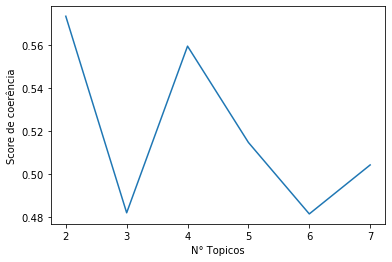

In [565]:
n_topics = tunin.groupby('Topics')['Coherence'].max()

# Show graph
limit=8; start=2; step=1;

x = range(start, limit, step)

plt.plot(x, n_topics)
plt.xlabel("N° Topicos")
plt.ylabel("Score de coerência")
plt.show()

## 4. Modelo Final

Iremos treinar o modelo de acordo com os hiperparâmetros $\alpha= asymmetric$, $\beta = 0.9$ e $K=2$. No ajuste foi utilizado o número de passos pequeno para não levar muito tempo, como agora iremos treinar o modelo uma vez, podemos aumentar o valor do passe. 

In [553]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=100,
                                           alpha="asymmetric",
                                           eta=0.9)

In [554]:
coherence_model_lda = compute_metrics(lda_model=lda_model, corpus=corpus, id2word=id2word)


Perplexity:  -7.092465294023134

Coherence Score:  0.5814373038132663


Abaixo vemos as palavras-chave de cada tópico e a ponderação de cada palavra-chave.

In [566]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.058*"muito" + 0.036*"muito_bom" + 0.031*"pratico" + 0.024*"otimo" + '
  '0.023*"excelente" + 0.018*"facil" + 0.016*"bom" + 0.015*"boa" + '
  '0.014*"rapido" + 0.010*"bem"'),
 (1,
  '0.007*"atualizacao" + 0.007*"fazer" + 0.007*"consigo" + 0.007*"nao" + '
  '0.006*"conta" + 0.006*"pra" + 0.006*"bank" + 0.006*"problema" + '
  '0.005*"atualizar" + 0.005*"cartao"')]


In [611]:
# Visualizando os Tópicos
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

c:\users\aline\desktop\python\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.127671  0.0       1        1  58.460003
0     -0.127671  0.0       2        1  41.540001, topic_info=    Category        Freq       Term       Total  loglift  logprob
27   Default  330.000000      muito  330.000000  30.0000  30.0000
52   Default  206.000000  muito_bom  206.000000  29.0000  29.0000
16   Default  175.000000    pratico  175.000000  28.0000  28.0000
75   Default  138.000000      otimo  138.000000  27.0000  27.0000
94   Default  131.000000  excelente  131.000000  26.0000  26.0000
..       ...         ...        ...         ...      ...      ...
163   Topic2   37.399933     sempre   66.658134   0.3006  -5.0198
109   Topic2   28.587622      banco   50.652756   0.3065  -5.2885
148   Topic2   33.931610       bank   81.151123   0.0065  -5.1172
78    Topic2   23.639843        uso   38.681435   0.3861  -5.4786
227   Topic2   26.968260   funciona   62.274734   0.0416  -5.3469

[109 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
669       1  0.985355  abrir
669       2  0.039414  abrir
464       1  0.067794   agil
464       2  0.949123   agil
628       1  0.951387  agora
...     ...       ...    ...
78        2  0.620453    uso
233       1  0.045186   util
233       2  0.948901   util
189       1  0.974670    ver
189       2  0.044303    ver

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

Com base nas palavras-chaves e no gráfico acima, podemos concluir que o modelo identidicou duas estruturas de tópicos bem distintas. 

Em seguida iremos realizar diversas funções para poder encontrar os tópicos, seus percentuais de contribuição para as reviews e suas palavras chaves.

In [601]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=original):
    
   
    sent_topics_df = pd.DataFrame()

    
    for i, row in enumerate(ldamodel[corpus]):
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
       
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  
                
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=original)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [602]:
#inserindo na base de tópicos informações da base original
df_dominant_topic.index = df2.index

df_dominant_topic["Sentiment"]    = df2["Sentiment"]
df_dominant_topic["App_Version"]  = df2["App Version Name"]
df_dominant_topic["Device"]       = df2["Device"]
df_dominant_topic["Date_Review"]  = df2["Review Last Update Date and Time"]


df_dominant_topic.head()



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Sentiment,App_Version,Device,Date_Review
2,0,0.0,0.8152,"muito, muito_bom, pratico, otimo, excelente, f...",Boa,Positivo,6.10.6,on5xelte,2019-10-01T00:34:35Z
3,1,1.0,0.9506,"atualizacao, fazer, consigo, nao, conta, pra, ...","Não consigo gerar a fatura em PDF, no mesmo fo...",Negativo,6.10.6,dreamlte,2019-10-01T00:44:18Z
5,2,0.0,0.8742,"muito, muito_bom, pratico, otimo, excelente, f...",Atende bem!,Positivo,6.10.6,ASUS_Z012D,2019-10-01T01:25:26Z
7,3,0.0,0.8768,"muito, muito_bom, pratico, otimo, excelente, f...",Rápido e prático,Positivo,6.10.6,albus,2019-10-01T01:55:51Z
8,4,0.0,0.8145,"muito, muito_bom, pratico, otimo, excelente, f...",Rapidez,Positivo,6.10.6,j5lte,2019-10-01T02:14:23Z


In [615]:
# Verificando qual é a review que mais reprenta cada tópico

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorteddf_mallet.Text

0    O aplicativo é muito bom.... A Turma do Banco ...
1    O banco mais arcaico em que tenho conta. Queri...
Name: Text, dtype: object

#### Resultado
Com base nos ultimos outputs e nas palavras-chaves encontradas pelo modelo, podemos dizer que os tópicos representam:
    - Tópico 0, reviews com experiências satisfatórias/positivas
    - Tópico 1. reviews experiências insatisfatórias/negativas
   

No próximo passo verificamos como classificamos os tópicos das reviews com os seus respectivos sentimentos.

In [603]:
pd.pivot_table(df_dominant_topic,index=["Dominant_Topic"],values=["Keywords"],columns=["Sentiment"],aggfunc='count')

Keywords                
Sentiment      Negativo Neutro Positivo
Dominant_Topic                         
0.0                 106     64     1835
1.0                 332    110      309

Calculando a acurácia de cada tópico encontrado, temos:
    - 0,85% para as reviews com sentimento positivo com tópico satisfatório
    - 0,75% para as reviews com sentimento negativo com tópico insatisfatório

#### Word Cloud

As palavras chaves de cada tópico.

In [606]:
# Cria wordclouds
cols = [color for name, color in mcolors.XKCD_COLORS.items()]

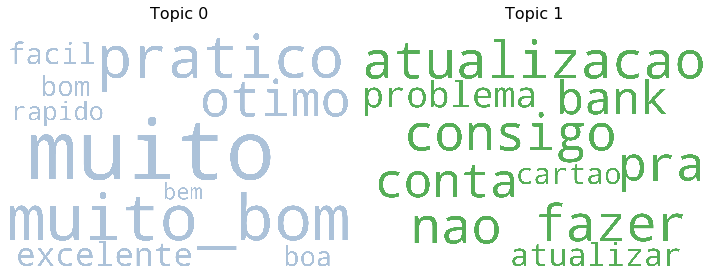

In [607]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##### Salvando o modelo que irá ser utilizado na análise do Power BI

In [608]:
df_dominant_topic.App_Version = df_dominant_topic.App_Version.str.replace('.', '-', regex=True)
df_dominant_topic = df_dominant_topic.drop(columns=['Document_No', 'Keywords','Sentiment'])

df_dominant_topic.to_csv('dados.csv', index=True)


## 5. Trabalhos Futuros

 Seria interesante numa próxima análise realizar a modelagem de tópicos para cada classe de sentimentos, provalmente se tiraria mais insights das reviews.
 Outro ponto seria utilizar outros modelos de reconhecimento de tópicos, como o Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA) e o Non Negative Matrix Factorization (NNMF).